In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/6th sem project"


'model (1).h5'					        test_essays.csv
 model_draft2.h5				        train_essays.csv
'new_approach_using_bert_and_vectorization (1).ipynb'   train_prompts.csv
 subtaskA_train_monolingual.jsonl		        train_v2_drcat_02.csv


In [3]:
!cp "/content/drive/My Drive/6th sem project/train_essays.csv" "train_essays.csv"
!cp "/content/drive/My Drive/6th sem project/test_essays.csv" "test_essays.csv"
!cp "/content/drive/My Drive/6th sem project/train_prompts.csv" "train_prompts.csv"
!cp "/content/drive/My Drive/6th sem project/train_v2_drcat_02.csv" "train_v2_drcat_02.csv"
!cp "/content/drive/My Drive/6th sem project/subtaskA_train_monolingual.jsonl" "subtaskA_train_monolingual.jsonl"

In [4]:
pip install tensorflow-text


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 38.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
    

In [5]:
!pip install sentencepiece

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import tensorflow_text as tf_text
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split


In [8]:
train_essays=pd.read_json("subtaskA_train_monolingual.jsonl",lines=True)
train_essays = pd.concat([train_essays.head(1000), train_essays.tail(1000)])
# train_essays=train_essays[['text','label']]
train_essays

,text,label,model,source,id
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4
...,...,...,...,...,...
119752,"The paper is an interesting contribution, prim...",0,human,peerread,119752
119753,\nWe thank the reviewers for all their comment...,0,human,peerread,119753
119754,The authors introduce a semi-supervised method...,0,human,peerread,119754
119755,This paper proposes the Neural Graph Machine t...,0,human,peerread,119755


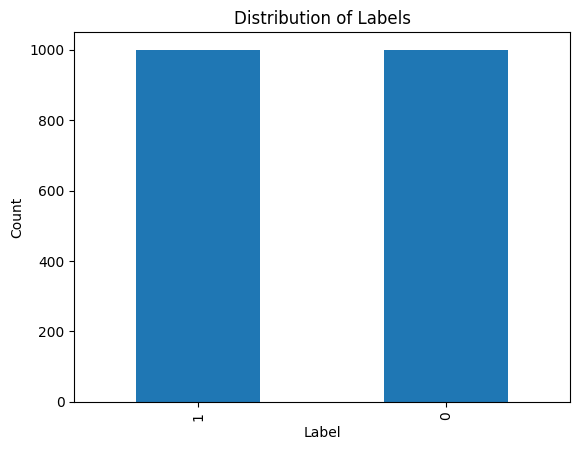

In [9]:
import matplotlib.pyplot as plt

# Count the occurrences of each label
label_counts = train_essays['label'].value_counts()

# Plot the bar graph
label_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show the plot
plt.show()


In [10]:
!pip install nltk
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [11]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:

# Text Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    words = text.split()  # Tokenize
    words = [word.lower() for word in words if word.isalpha()]  # Lowercase and remove non-alphabetic words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

train_essays['clean_text'] = train_essays['text'].apply(clean_text)

In [13]:
print(train_essays['clean_text'])

0         forza motorsport popular racing game provides ...
1         buying virtual console games nintendo wii fun ...
2         windows nt popular operating system back day s...
3         make perfume perfume great way enhance persona...
4         convert song lyrics song converting song lyric...
                                ...                        
119752    paper interesting contribution primarily gener...
119753    thank reviewers comments however would like re...
119754    authors introduce semisupervised method neural...
119755    paper proposes neural graph machine adds graph...
119756    paper proposes model aims learning label nodes...
Name: clean_text, Length: 2000, dtype: object


In [14]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_essays['clean_text'], train_essays['label'], test_size=0.2, random_state=42)


In [15]:
from transformers import DebertaForSequenceClassification, DebertaTokenizer
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', padding=True, truncation=True, max_length=128)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [16]:
encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')

In [17]:
train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)

In [18]:
# Create TensorDatasets
train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)

In [19]:
# DataLoader for efficient processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [20]:
# Define the DeBERTa model for sequence classification
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

In [21]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 10

In [22]:
import torch
import torch.nn as nn

In [23]:
model.train()

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

In [24]:
loss_fn = nn.CrossEntropyLoss()

In [25]:


# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0

    # Iterate over batches
    for batch in train_loader:
        # Move batch to device
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.cuda(), attention_mask.cuda(), labels.cuda()  # Move tensors to CUDA device

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)

        # Compute loss
        loss = loss_fn(outputs.logits, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Print epoch loss
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 91.06 MiB is free. Process 3843 has 14.66 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 12.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)